Analysis of the winding parameters of a 1250 kVA Superconducting Transformer
-------------------------------------------------------------------------------------------------------------------

The transformer and its parameters originally published in DOI:10.1109/TASC.2014.2345349.

Main parameters of the  transformer:

- $S_n$ = 1250 kVA - nominal power
- $f$ = 50 Hz - network frequency
- $\epsilon$ = 5.8 % - short circuit impedance
- $U_1 / U_2$ = 10.5 kV / 0.4 kV
- $I_1 / I_2$ = 69 A / 1804 A
- Connection group: YNyn0


In [1]:
import os
import sys
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from src.base_functions import turn_voltage,short_circuit_impedance
from src.superconductor_losses import thermal_incomes, cryo_surface,cryostat_losses
from src.diagrams import plot_winding_flux

Calculating the turn voltage and the filling factors from the main winding parameters:

In [2]:
# seconday - outer, primary inner winding
Np = 262.0 # turns in the primary winding
Up = 10500 # V 
utp = Up/Np/1.73
print("Turn voltage from primary winding data: ", round(utp,2), "V")

# secondary winding
Ns = 10
Us = 400
uts= Us/1.73/Ns
print("Turn voltage from secondary winding data:",round(uts,2), "V")

# BSSCO tape dimensions
w = 4.8  # mm
h = 0.32 # mm
A = 4.8*0.32 # 1.536 mm2

# Winding areas
a_lv = 13.5 * 342.5 # mm
a_hv = 8* 355

Nd = 22 # number of discs/pancakes
ff_lv = A*Np/a_lv*100
ff_hv = A*Ns*Nd/a_hv*100

print('Filling factor in LV (primary) winding', round(ff_lv,2), '%')
print('Filling factor in HV (secondary) winding',round(ff_hv,2), '%')

I1 = 69.
I2 = 1804.

ae_lv = (a_lv*(ff_lv/100))
ae_hv = (a_hv*(ff_hv/100))

print("Amperturns should balanced:", I1*Np, I2*Ns)

j_lv = I1*Np/ae_lv
j_hv = I2*Ns/ae_hv

print('j in LV:',round(j_lv,2), 'A/mm2', round(ae_lv,1), round(a_lv,1))
print('j in HV:',round(j_hv,2), 'A/mm2', round(ae_hv,1), round(a_hv,1))


Turn voltage from primary winding data:  23.17 V
Turn voltage from secondary winding data: 23.12 V
Filling factor in LV (primary) winding 8.7 %
Filling factor in HV (secondary) winding 11.9 %
Amperturns should balanced: 18078.0 18040.0
j in LV: 44.92 A/mm2 402.4 4623.8
j in HV: 53.39 A/mm2 337.9 2840


Independent design parameters for the two-winding transformer model:

- $r_c$ core radius : 155 mm
- $b_c$ flux density: 1.5 T
- $j_{in}$ current density in the inner winding: 44.92 $A/mm^2$ -- 100% filling factor assumed
- $j_{ou}$ current density in the outer winding: 53.39 $A/mm^2$
- $h_{in}$ the height of the inner winding: 342.5 mm
- $m_{gap}$ main gap - the distance between two main windings: 34.5 mm

Cooling System:

- Cryostat inner / outer diameter: 330/740 mm
- Operation temperature: 77 K


The core filling factor in the core's column was calculated from the other calculation of the turn voltage:

In [3]:
ut = turn_voltage(1.5, 155.0, 0.92, 50.0)
print('turn voltage:',round(ut,2), 'V')

sci = short_circuit_impedance(1250., 3, 50, 1.03, 23.1, 342.5, 0, 205, 13.5, 253, 8., 34.5)
print('SCI:',sci, '%')

turn voltage: 23.12 V
SCI: 5.29 %


The calculated short circuit impedance (5.29%) is smaller than the given data in the paper, but it can be acceptable. Because the model contains a special HV winding where the size of  the top and bottom pancake is differs from the other parts of the winding.

The goal of the following code calculates all of the parameters by the built-in two winding model of the transformer. All of the data of the LV and HV windings (inner/outer radius, losses, amperturns) calculated from the independent variables and  

In [4]:
from importlib_resources import files
from src.two_winding_model import TransformerDesign, TwoWindingModel

path = files("data").joinpath("1250kVA_sc_transformer.json")

import json

with open(path) as json_file:
    data = json.load(json_file)

transformer = TransformerDesign.from_dict(data)

trafo_model = TwoWindingModel(input=transformer)
trafo_model.calculate(is_sc=True)
print("LV winding:")
print(trafo_model.lv_winding)
print("HV winding:")
print(trafo_model.hv_winding)

LV winding:
WindingDesign(inner_radius=205.1, thickness=13.5, winding_height=342.5, filling_factor=8.7, current_density=44.92, mass=10.3, dc_loss=0.0, ac_loss=1663.0666171977766, outer_radius=218.6, cable_length=1266.23, amper_turns=18069.8)
HV winding:
WindingDesign(inner_radius=253.1, thickness=8.2, winding_height=356.2, filling_factor=11.6, current_density=53.45, mass=10.5, dc_loss=0.0, ac_loss=1695.3499918222296, outer_radius=261.3, cable_length=1290.81, amper_turns=18109.8)


Mesh Generator: Initial mesh generation
Mesh generator: Triangle
Mesh Generator: Reading initial mesh from memory
Solver: Solver - MUMPS (none)
Solver: Elapsed time: 00:00.875 s
Magnetic Energy 36.1038335428817
zb, ib: 88.2 ohm 68.73 A
SCI: 5.44 [%]
Bax  [HV] = 63.88 [mT]
Brad [HV] = 34.93 [mT]
Bax  [LV] = 56.39 [mT]
Brad [Lv] = 32.7 [mT]


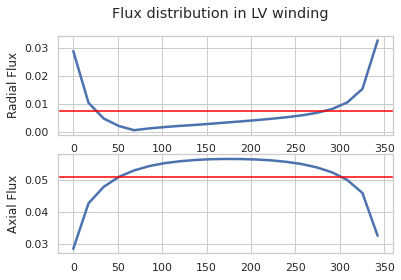

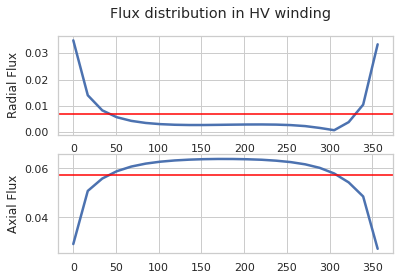

In [5]:
# FEM calculation
trafo_model.fem_simulation(detailed_output = True)

Detailed calculation of the superconducting losses and validating the results in the comparison with the published papers:

a_cs: 3188323.844311941
29.08
hv: 0.7448746890442886 W/m
lv: 0.7492035894348527 ,W/m
hv average: 0.13 W/m
lv average: 0.115 W/m


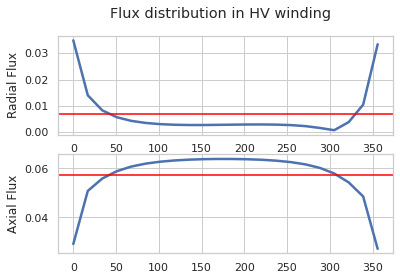

In [6]:
from src.superconductor_losses import cryo_surface,cryostat_losses, magnusson_ac_loss, supra_winding_ac_loss
a_cs = cryo_surface(205.0, 370, 800)  # [mm2]
cryo_loss = cryostat_losses(a_cs)
#thermal_loss = thermal_incomes(self.input.required.lv.ph_current, self.input.required.hv.ph_current)

print('a_cs:',a_cs)
#print('cryostat losses:', cryo_loss)
print(cryo_loss)

# HV winding
print('hv:',magnusson_ac_loss(63.89*1e-3, 34.39*1e-3, 50, 69, Ic=115), 'W/m')
print('lv:',magnusson_ac_loss(56.38*1e-3, 34.39*1e-3, 50, 1804/20, Ic=115), ',W/m')

# Calculation with the averaged values of Bax and Brad along the winding
B_hv = [(0.029128001810690196, 0.034931126895950015), (0.050827730564536266, 0.013995471297917561), (0.05588725071682793, 0.008240268880776114), (0.05886954390963839, 0.005638255023196592), (0.06077329192829234, 0.004242084637681387), (0.06198176035801467, 0.003445644623909061), (0.06276385272892504, 0.002995500599112688), (0.06327437776653683, 0.002760552277617734), (0.06359944969665898, 0.002661568692436944), (0.06379442937349428, 0.0026641586971951625), (0.06388059481829217, 0.002728564552750612), (0.06386326031218509, 0.0028002328471558036), (0.06375556424426587, 0.0028587919261724437), (0.06355546873347745, 0.0028738248556079427), (0.06317272884807773, 0.0028134675986741797), (0.06259672900939289, 0.0026311711550385253), (0.061686454242632804, 0.0022513791514020554), (0.06025066397296713, 0.0015527807458504128), (0.05795286910805797, 0.000685192255041045), (0.054315535780667834, 0.003759431911852573), (0.048564227979538355, 0.010423416210258551), (0.027189030612877307, 0.03342143530190356)]
print('hv average:',supra_winding_ac_loss(B_hv, 50, 69, Ic=170, kappa=2.0), 'W/m')

B_lv = [(0.02856165890911766, 0.028847904921676104), (0.04264701220871581, 0.010333326005571797), (0.04776295819421883, 0.004720985033777048), (0.05085840666736541, 0.002039399273394693), (0.052852837699169486, 0.0005450278785072982), (0.05419566215315297, 0.0011922709959351074), (0.055091261307798844, 0.0016744365020429086), (0.05568369741614443, 0.002085502906240322), (0.05606747169313475, 0.0024392793956877767), (0.05631371035279775, 0.00283595546320603), (0.05639469993875801, 0.0032735437949860113), (0.05636608292796119, 0.0036982745586362498), (0.056231994280278585, 0.004135042743796724), (0.0559625196568071, 0.004626368660648694), (0.05550011895636897, 0.005175337428187099), (0.054825977114110414, 0.005848641399257559), (0.05378865098492425, 0.006752316481653198), (0.05225866137292812, 0.008116694915730749), (0.04990585466674591, 0.01048128371018553), (0.04584717417017381, 0.015320514277157304), (0.03259398082720333, 0.032704985099393014), (0.018490895738829893, 0.013055647487121291)]
print('lv average:',supra_winding_ac_loss(B_lv, 50, 69, Ic=170, kappa=1.5), 'W/m')

# flux distribution along the HV winding
plot_winding_flux(B_hv, 0, 356)


Calculating the total AC loss of the windings from the above two results. The first two values uses the maximum values of the axial and the radial fields to calculate the ac losses in the windings, while the second case calculates the ac loss for 21 segments of the windings and average these values.

At first, the length of the superconducting tapes can be approximated by:

In [7]:
r_m = 205
length = Np * 2*r_m*3.14 * 1e-3 
print(round(length*3,1), 'm')

length_sec = 10*22*2*3.14*1e-3*253
print(round(length_sec*3,1))

1011.9 m
1048.6


The losses in the windings from the maximal values:

In [8]:
P_ac_max = length*0.745*3 + length_sec*0.75*3
P_ac_avg = length*0.13*3 + length*0.115*3

print('P_ac (max) = ', round(P_ac_max))
print('P_ac (avg) = ',round(P_ac_avg))

P_ac (max) =  1540
P_ac (avg) =  248


**Thermal incomes**

The six current leads are major sources of heat ingress to the cryostat. The minimum heat leak for metal heat lead at its design current is about 42 W/kA. 

In DOI: 10.1109/TASC.2016.2639032, the measured 1 MVA transformer heat losses are estimated about 345 W, while the AC losses are about 360 W. 
This quantity should be similar like the investigated transformer.

In this case the thermal incomes can be calculated from the phase current of the transformer. 

In [9]:
pt = thermal_incomes(69,1804)
print('Thermal losses:', pt, 'W')

Thermal losses: 505.71 W


**Cryostat Losses**

Other significant part of the losses created by the cryostat of the transformer:

In [10]:
r_in = 330./2
r_ou = 740./2
h = 360.
A_cr = cryo_surface(r_in, r_ou, h)
P_cr =cryostat_losses(A_cr, dT=228.0)
print("Cryostat losses in the three phase:",P_cr*3, "W")

Cryostat losses in the three phase: 42.54 W


**The total losses** 

$P_{ac}$ = 252 + 42.54 +505.7 ~ 800 W